In [34]:
# parsing CoNLL+WikiNEuRal folder

# !pip install datasets

from datasets import load_dataset
import pandas as pd
import re
import time
import json
from sklearn.model_selection import train_test_split
import numpy as np

In [35]:
def parse_file_data(path, in_position, pos_position, line_len, sep):
    dataset = []
    f = open(path, encoding="utf8") 
    input_sentence = ''
    target_output = ''
    word_count = 0
    NE_count = 0
    
    for row in f:  
        row = row.split(sep)
        
        if '-DOCSTART-' in row[0]:
            continue
        
        if row[0] == "\n" and input_sentence != "": ############# keep in mind, make sure it is correct
            if(target_output == ''):
                target_output = '**'
            dataset.append([input_sentence, target_output, word_count, NE_count])
            input_sentence = ''
            target_output = ''
            word_count = 0
            NE_count = 0
            continue

        if len(row) <line_len:
            continue
        elif len(row) != line_len:
            print("something is wrong, length is diff: ", row)
        
        # to remove the '\n' at the end
        if row[-1] == '\n':
            row = row[:-1]
        elif '\n' in row[-1]:
            row[-1] = row[-1].replace('\n', '')

        word = row[in_position]
        pos_tag = row[pos_position]
        
        # adding word to input sentence
        if input_sentence == "": 
            input_sentence = word
        else:
            if word == "'s" and pos_tag.startswith('I-'):
                input_sentence = input_sentence + word
            else: 
                input_sentence = input_sentence + " " + word
        
        if len(re.sub(r'[\W\s]', '', word)):
            word_count += 1
            
        
        # adding entity word to target sentence
        if pos_tag != 'O': 
            if len(re.sub(r'[\W\s]', '', word)):
                NE_count += 1
            if target_output == '':
                target_output = f'*{word}*'
        
            elif pos_tag.startswith('B-'):
                target_output = f'{target_output},*{word}*'
            elif pos_tag.startswith('I-'):
                if word == "'s":
                    target_output = f'{target_output[:-1]}{word}*'
                else:
                    target_output = f'{target_output[:-1]} {word}*'
            else: 
                print('error')
                print(pos_tag)      
    f.close()

    parsed_data = pd.DataFrame(dataset, columns=['input_text', 'target_text', 'word_count', 'NE_count'])
    return parsed_data

In [36]:
def read_hugging_face_data(row):
    input_sentence = ''
    target_output = ''
    NE_count = 0
    word_count = len(row['tokens'])
    
    for i in range(word_count):    
        word = row['tokens'][i]
        pos_tag = row['ner_tags'][i]
        
        # adding word to input sentence
        if input_sentence == '': 
            input_sentence = word
        else:
            if word == "'s" and pos_tag!=0 and pos_tag%2:
                input_sentence = input_sentence + word
            else: 
                input_sentence = input_sentence + " " + word
            
        # adding entity word to target sentence
        if pos_tag != 0: 
            if len(re.sub(r'[\W\s]', '', word)):
                NE_count += 1
            if target_output == '':
                target_output = f'*{word}*'
        
            elif pos_tag%2:
                target_output = f'{target_output},*{word}*'
            elif not(pos_tag%2):
                if word == "'s":
                    target_output = f'{target_output[:-1]}{word}*'
                else:
                    target_output = f'{target_output[:-1]} {word}*'
            else: 
                print('error')
                print(pos_tag)      
    if not target_output:
        target_output = '**'
    return pd.Series([input_sentence, target_output, word_count, NE_count])

In [37]:
def read_onto_dataset():
    dataset = {'input_text':[], 'target_text': [], 'word_count': [], 'NE_count': []}
    with open('./1-NER_Data/0-raw_data/ontoNotes_5.0/ontonotes5.json', encoding="utf8") as f:
        # returns JSON object as a dictionary
        data = json.load(f)
        
    for sent in data['TRAINING']:
        if sent['language'] != 'english':
            continue
        
        ne_count = 0
        input_sent = sent['text']
        word_count = len(sent['text'].split())
        target_ent = ''
        for entities in sent['entities'].values():
            ne_count += 1
            for (i,j) in entities:
                target_ent = f'{target_ent}*{input_sent[i:j]}*,'

        dataset['input_text'].append(input_sent)
        if not target_ent:
            target_ent = '**'
        else:
            target_ent = target_ent[:-1]
        dataset['target_text'].append(target_ent)
        dataset['word_count'].append(word_count)
        dataset['NE_count'].append(ne_count)
    return pd.DataFrame(dataset) 

In [38]:
def add_per_NE_sent(data):
    data['%_NE_in_sentence'] = round(data['NE_count']/ data['word_count'], 1)
    return data

In [39]:
# expects a dataframe
def lower_case_df(data):
    low_input_text = data["input_text"].str.lower()
    low_target_text = data["target_text"].str.lower()
    return create_dataframe(low_input_text, low_target_text)

In [40]:
# expects a dataframe
def upper_case_df(data):
    upper_input_text = data["input_text"].str.upper()
    upper_target_text = data["target_text"].str.upper()
    return create_dataframe(upper_input_text, upper_target_text)

In [41]:
def create_dataframe(input_sent, target_sent):
    data = []
    for input_text, target_text in zip(input_sent, target_sent):
        data.append([input_text, target_text])

    return pd.DataFrame(data, columns=['input_text', 'target_text'])

## Reading the onto_data and splitting the data into training, validation and test sets

In [42]:
onto_data = read_onto_dataset()
onto_data = onto_data.sample(frac=1, random_state=1).reset_index(drop=True)
onto_training, onto_test = train_test_split(onto_data, test_size=0.3)
onto_test, onto_val = train_test_split(onto_test, test_size=0.5)

In [43]:
onto_training

,input_text,target_text,word_count,NE_count
54240,She took her business to First Atlanta.,*First Atlanta*,7,1
26621,"After all, this is n't old money, but new mone...",**,16,0
22047,You do n't want a relationship?,**,6,0
81561,`` The situation you want to avoid is having s...,**,29,0
26663,Well no,**,2,0
...,...,...,...,...
15833,The rating agency said about $ 85 million in s...,*about $ 85 million*,12,1
104412,The last time IBM tapped the corporate debt ma...,"*April 1988*,*$ 500 million*,*IBM*",22,3
67234,By giving them power to do miracles the Lord p...,**,15,0
84332,"`` I'm the secretary-general, if there is one,...",**,17,0


In [21]:
len(onto_data)

131980

In [22]:
print(len(onto_training))
print(len(onto_test))
print(len(onto_val))

92386
19797
19797


# Training data

### Read the data from either txt files or from huggingface dataset and converting each to target form  --->  [input_text, target_text, word_count, NE_count] 

In [31]:
# CoNLL2003++ training dataset

conellpp_training = parse_file_data("./1-NER_Data/0-raw_data/coNLL2003pp/conllpp_train.txt", in_position=0, pos_position=3, line_len=4, sep=' ')
conellpp_training

,input_text,target_text,word_count,NE_count
0,EU rejects German call to boycott British lamb .,"*EU*,*German*,*British*",8,3
1,Peter Blackburn,*Peter Blackburn*,2,2
2,BRUSSELS 1996-08-22,*BRUSSELS*,2,1
3,The European Commission said on Thursday it di...,"*European Commission*,*German*,*British*",29,4
4,Germany 's representative to the European Unio...,"*Germany*,*European Union*,*Werner Zwingmann*,...",30,6
...,...,...,...,...
14036,on Friday :,**,2,0
14037,Division two,**,2,0
14038,Plymouth 2 Preston 1,"*Plymouth*,*Preston*",4,2
14039,Division three,**,2,0


In [33]:
conellpp_training.iloc[4]

input_text     Germany 's representative to the European Unio...
target_text    *Germany*,*European Union*,*Werner Zwingmann*,...
word_count                                                    30
NE_count                                                       6
Name: 4, dtype: object

In [14]:
# wikineural training dataset

wikineural_training = parse_file_data("./1-NER_Data/0-raw_data/wikineural/train.conllu.txt", 1, 2, 3, '\t')
wikineural_training

,input_text,target_text,word_count,NE_count
0,This division also contains the Ventana Wilder...,"*Ventana Wilderness*,*California*",12,3
1,""" So here is the balance NBC has to consider :...","*NBC*,*The Who*,*Animal Practice*",13,5
2,"It is a protest song that "" creates a cinemati...",*America*,36,1
3,This differs from approaches such as IP or Eth...,*Ethernet*,16,1
4,"Since then , only Terry Bradshaw in 147 games ...","*Terry Bradshaw*,*Joe Montana*,*Tom Brady*",25,6
...,...,...,...,...
92715,"The couple had a son , David , and a daughter ...","*David*,*Sarah*",10,2
92716,"The Home Secretary , J. R. Clynes , was presen...",*J. R. Clynes*,12,3
92717,"At the time of her birth , she was fourth in t...",*British throne*,18,2
92718,The film was based on the Broadway play of the...,*Broadway*,12,1


In [12]:
# OntoNotes 5.0 training dataset refer section above

### Adding entity as percentage of the input sentence

In [13]:
conellpp_training = add_per_NE_sent(conellpp_training)
wikineural_training = add_per_NE_sent(wikineural_training)
onto_training = add_per_NE_sent(onto_training)

#### conell++ training dataset

14041
there are 0.2383021152339577 sentences in the range of 0:0.1
3346


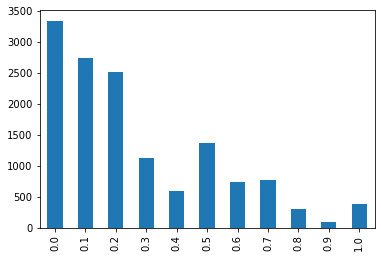

In [14]:
plot_percent_NE = conellpp_training['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print(len(conellpp_training))
print("there are", sum(plot_percent_NE.loc[0:0.01])/len(conellpp_training), "sentences in the range of 0:0.1")
print(sum(plot_percent_NE.loc[0:0.01]))

<AxesSubplot:xlabel='word_count'>

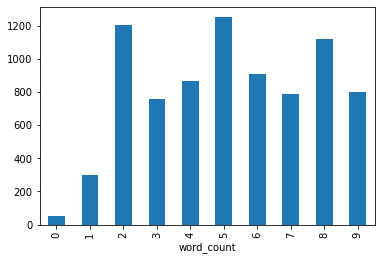

In [15]:
conellpp_training.groupby(by='word_count')['input_text'].count().head(10).plot(kind='bar')

In [16]:
conellpp_training = conellpp_training.drop(conellpp_training.loc[conellpp_training['word_count'] == 0].index).reset_index(drop=True)
conellpp_training

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,EU rejects German call to boycott British lamb .,"*EU*,*German*,*British*",8,3,0.4
1,Peter Blackburn,*Peter Blackburn*,2,2,1.0
2,BRUSSELS 1996-08-22,*BRUSSELS*,2,1,0.5
3,The European Commission said on Thursday it di...,"*European Commission*,*German*,*British*",29,4,0.1
4,Germany 's representative to the European Unio...,"*Germany*,*European Union*,*Werner Zwingmann*,...",30,6,0.2
...,...,...,...,...,...
13985,on Friday :,**,2,0,0.0
13986,Division two,**,2,0,0.0
13987,Plymouth 2 Preston 1,"*Plymouth*,*Preston*",4,2,0.5
13988,Division three,**,2,0,0.0


#### Wikineiral training dataset

92720
there are 0.14910483175150993 sentences in the range of 0:0.1
13825


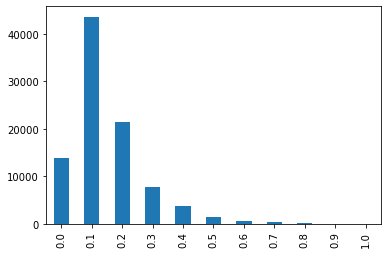

In [17]:
plot_percent_NE = wikineural_training['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print(len(wikineural_training))
print("there are", sum(plot_percent_NE.loc[0:0.01])/len(wikineural_training), "sentences in the range of 0:0.1")
print(sum(plot_percent_NE.loc[0:0.01]))

<AxesSubplot:xlabel='word_count'>

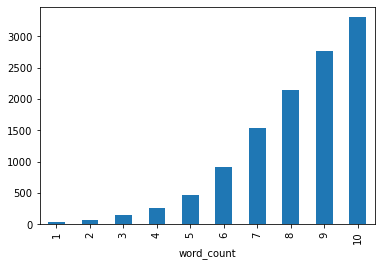

In [18]:
wikineural_training.groupby(by='word_count')['input_text'].count().head(10).plot(kind='bar')

#### Onto training dataset

92386
there are 0.6287749226073215 sentences in the range of 0:0.1
58090


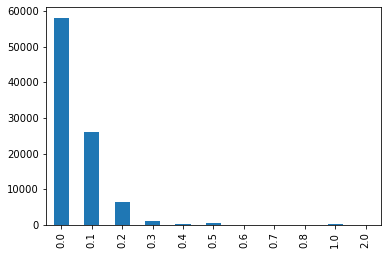

In [19]:
plot_percent_NE = onto_training['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print(len(onto_training))
print("there are", sum(plot_percent_NE.loc[0:0.01])/len(onto_training), "sentences in the range of 0:0.1")
print(sum(plot_percent_NE.loc[0:0.01]))

In [20]:
# dropping half of the rows with zero entities randomly

np.random.seed(10)
zero_entities = onto_training.loc[onto_training['%_NE_in_sentence']==0].index
#TODO: take 1/5 of the entities with 0 entities .. so that the overall (combined) dataset has less than or equal to 15%
remove_n = round(len(zero_entities)*2/3)


drop_indices = np.random.choice(zero_entities, remove_n, replace=False)
onto_training = onto_training.drop(drop_indices).reset_index(drop=True)
onto_training

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,"We, including US President Bush, who came to P...","*US*,*Pusan*,*Japan*,*China*,*Sino-Japanese*,*...",36,3,0.1
1,About eight firms will get the lion's share.,*About eight*,8,1,0.1
2,Do n't you know you are worth much more than t...,**,13,0,0.0
3,"Insurers, such as Cigna Corp., Transamerica Co...","*one*,*U.S.*,*Cigna Corp.*,*Transamerica Corp*...",29,3,0.1
4,"I have seen my people suffering, and I have he...",**,15,0,0.0
...,...,...,...,...,...
53654,I find them fascinating.,**,4,0,0.0
53655,No.,**,1,0,0.0
53656,but that's the ground equipment uh that we 're...,**,15,0,0.0
53657,Some American officers interpreted his eagerne...,*American*,18,1,0.1


53659
there are 0.3608527926349727 sentences in the range of 0:0.1
19363


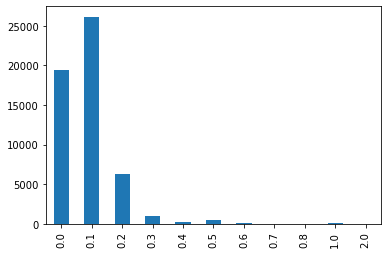

In [21]:
plot_percent_NE = onto_training['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print(len(onto_training))
print("there are", sum(plot_percent_NE.loc[0:0.01])/len(onto_training), "sentences in the range of 0:0.1")
print(sum(plot_percent_NE.loc[0:0.01]))

<AxesSubplot:xlabel='word_count'>

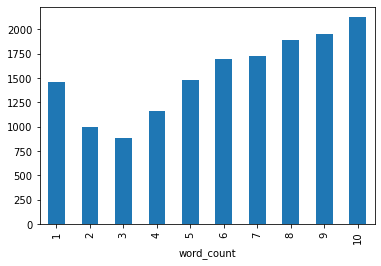

In [22]:
onto_training.groupby(by='word_count')['input_text'].count().head(10).plot(kind='bar')

### Combining the datasets

In [23]:
combined_df = pd.concat([conellpp_training, wikineural_training, onto_training], ignore_index=True)
combined_df = combined_df.drop_duplicates().reset_index(drop=True)
combined_df

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,EU rejects German call to boycott British lamb .,"*EU*,*German*,*British*",8,3,0.4
1,Peter Blackburn,*Peter Blackburn*,2,2,1.0
2,BRUSSELS 1996-08-22,*BRUSSELS*,2,1,0.5
3,The European Commission said on Thursday it di...,"*European Commission*,*German*,*British*",29,4,0.1
4,Germany 's representative to the European Unio...,"*Germany*,*European Union*,*Werner Zwingmann*,...",30,6,0.2
...,...,...,...,...,...
157319,Featuring aboriginal folk songs and a renditio...,"*10,000*,*ROC*,*Chinese*",31,3,0.1
157320,I find them fascinating.,**,4,0,0.0
157321,but that's the ground equipment uh that we 're...,**,15,0,0.0
157322,Some American officers interpreted his eagerne...,*American*,18,1,0.1


### creating a lowercase and uppercase versions of the training data (not needed)

In [24]:
lower_training = lower_case_df(combined_df)
lower_training

,input_text,target_text
0,eu rejects german call to boycott british lamb .,"*eu*,*german*,*british*"
1,peter blackburn,*peter blackburn*
2,brussels 1996-08-22,*brussels*
3,the european commission said on thursday it di...,"*european commission*,*german*,*british*"
4,germany 's representative to the european unio...,"*germany*,*european union*,*werner zwingmann*,..."
...,...,...
157319,featuring aboriginal folk songs and a renditio...,"*10,000*,*roc*,*chinese*"
157320,i find them fascinating.,**
157321,but that's the ground equipment uh that we 're...,**
157322,some american officers interpreted his eagerne...,*american*


In [25]:
upper_training = upper_case_df(combined_df)

In [26]:
lower_normal_training = pd.concat([lower_training, combined_df])
lower_normal_training = lower_normal_training.sample(frac=1, random_state=1).reset_index(drop=True)
lower_normal_training

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,in the south the range extends westwards from ...,"*victoria*,*yorke peninsula*,*flinders ranges*...",NaN,NaN,NaN
1,Although the primary tone hole pitches are a p...,*English*,32.0,1.0,0.0
2,A second co-defendant's lawyer was gunned down.,*second*,7.0,1.0,0.1
3,The lists total $ 654.5 million.,*$ 654.5 million*,6.0,1.0,0.2
4,"verbs which fall into this category include "" ...",*carinthia*,NaN,NaN,NaN
...,...,...,...,...,...
314643,it was the last of several speeches he has mad...,*recent weeks*,NaN,NaN,NaN
314644,the annual grand national horse race takes pla...,"*grand national*,*aintree racecourse*",NaN,NaN,NaN
314645,Thus we gained a great deal from attending.,**,8.0,0.0,0.0
314646,We saw the star that shows he was born.,**,9.0,0.0,0.0


In [27]:
lower_normal_upper_training = pd.concat([lower_training, combined_df, upper_training])
lower_normal_upper_training = lower_normal_upper_training.sample(frac=1, random_state=1).reset_index(drop=True)
lower_normal_upper_training

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,"In 1624 , the last of the monks died and the a...","*Robert Spottiswoode*,*St Andrews*,*New Abbey*",38.0,6.0,0.2
1,"For example , her view of the subject , and it...","*Sigmund Freud*,*Lacan*",17.0,3.0,0.2
2,THE DOW JONES INDUSTRIAL AVERAGE OPENED SLIGHT...,"*DOW JONES*,*PHILIP MORRIS*",NaN,NaN,NaN
3,"the aviary is home to about 100 birds , most b...","*inca*,*magellanic*",NaN,NaN,NaN
4,Further illustrating the popularity of the cha...,*Her Highness Silk Hit Comics*,24.0,5.0,0.2
...,...,...,...,...,...
471967,"WHEREBY EXPORTS TO EU COUNTRIES GREW BY 32,2 %...",*EU*,NaN,NaN,NaN
471968,Thus we gained a great deal from attending.,**,8.0,0.0,0.0
471969,We saw the star that shows he was born.,**,9.0,0.0,0.0
471970,"BY A 6-4 MARGIN, HOUSE NEGOTIATORS INITIALLY R...","*6*,*HOUSE*,*SENATE*,*LAST NIGHT*",NaN,NaN,NaN


### Saving the data as csv

In [28]:
combined_df.to_csv('./1-NER_Data/1-csv_format/train/training_data.csv', index = False)
lower_normal_training.to_csv('./1-NER_Data/1-csv_format/train/lower_normal_training.csv', index = False)
lower_normal_upper_training.to_csv('./1-NER_Data/1-csv_format/train/lower_normal_upper_training.csv', index = False)

# Validation data

### Read the data from either txt files or from huggingface dataset and converting each to target form  --->  [input_text, target_text, word_count, NE_count] 

In [17]:
# CoNLL2003++ validatoin dataset

conellpp_val = parse_file_data("./1-NER_Data/0-raw_data/coNLL2003pp/conllpp_dev.txt", in_position=0, pos_position=3, line_len=4, sep=' ')
conellpp_val

,input_text,target_text,word_count,NE_count
0,CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTE...,*LEICESTERSHIRE*,9,1
1,LONDON 1996-08-30,*LONDON*,2,1
2,West Indian all-rounder Phil Simmons took four...,"*West Indian*,*Phil Simmons*,*Leicestershire*,...",34,6
3,"Their stay on top , though , may be short-live...","*Essex*,*Derbyshire*,*Surrey*,*Kent*,*Nottingh...",33,5
4,After bowling Somerset out for 83 on the openi...,"*Somerset*,*Grace Road*,*Leicestershire*,*Engl...",36,7
...,...,...,...,...
3245,But the prices may move in a close range follo...,**,14,0
3246,"Brokers said blue chips like IDLC , Bangladesh...","*IDLC*,*Bangladesh Lamps*,*Chittagong Cement*,...",17,7
3247,They said there was still demand for blue chip...,**,21,0
3248,The DSE all share price index closed 2.73 poin...,*DSE*,24,1


In [18]:
# wikineural validation dataset

wikineural_val = parse_file_data("./1-NER_Data/0-raw_data/wikineural/val.conllu.txt", 1, 2, 3, '\t')
wikineural_val

,input_text,target_text,word_count,NE_count
0,Her visit to Tuvalu was cut short by an illnes...,"*Tuvalu*,*Australia*",24,2
1,"In 1975 , the Princess was listed among women ...",*Warren Beatty*,17,2
2,"In 1974 , she invited him as a guest to the ho...",*Mustique*,17,1
3,She co-starred with Richard Widmark and Gig Yo...,"*Richard Widmark*,*Gig Young*,*The Tunnel of L...",32,14
4,She experienced a mild stroke on 23 February 1...,*Mustique*,15,1
...,...,...,...,...
11585,"However , he played his home games at Baker Bo...",*Baker Bowl*,18,2
11586,256 with 11 triples in 277 at bats when his co...,*Chicago White Sox*,21,3
11587,He played his final professional games in 1922...,*Minneapolis Millers*,12,2
11588,The city is also the setting for the Disney Ch...,"*Disney Channel*,*Good Luck Charlie*",14,5


In [31]:
# OntoNotes 5.0 validation dataset refer section above

### Adding entity as percentage of the input sentence

In [32]:
conellpp_val = add_per_NE_sent(conellpp_val)
wikineural_val = add_per_NE_sent(wikineural_val)
onto_val = add_per_NE_sent(onto_val)

there are 0.23076923076923078 sentences in the range of 0:0.1


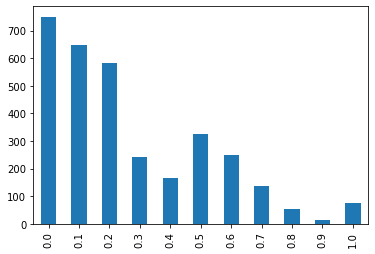

In [33]:
plot_percent_NE = conellpp_val['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print("there are", sum(plot_percent_NE.loc[0:0.099])/len(conellpp_val), "sentences in the range of 0:0.1")

<AxesSubplot:xlabel='word_count'>

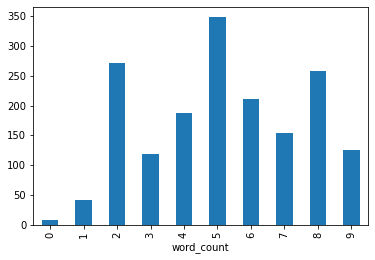

In [34]:
conellpp_val.groupby(by='word_count')['input_text'].count().head(10).plot(kind='bar')

In [35]:
conellpp_val = conellpp_val.drop(conellpp_val.loc[conellpp_val['word_count'] == 0].index).reset_index(drop=True)
# conellpp_val

there are 0.13701466781708369 sentences in the range of 0:0.1


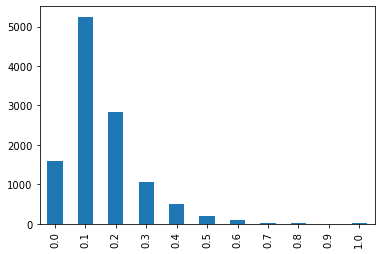

In [36]:
plot_percent_NE = wikineural_val['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print("there are", sum(plot_percent_NE.loc[0:0.099])/len(wikineural_val), "sentences in the range of 0:0.1")

<AxesSubplot:xlabel='word_count'>

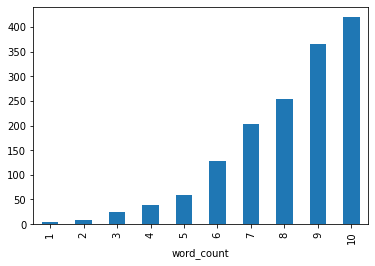

In [37]:
wikineural_val.groupby(by='word_count')['input_text'].count().head(10).plot(kind='bar')

19797
there are 0.6274182957013689 sentences in the range of 0:0.1
12421


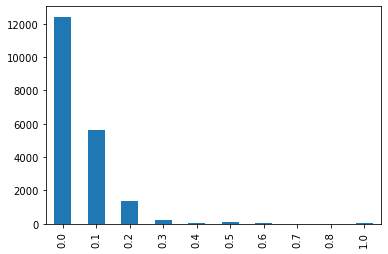

In [38]:
plot_percent_NE = onto_val['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print(len(onto_val))
print("there are", sum(plot_percent_NE.loc[0:0.099])/len(onto_val), "sentences in the range of 0:0.1")
print(sum(plot_percent_NE.loc[0:0.01]))

In [39]:
# dropping half of the rows with zero entities randomly

np.random.seed(10)
zero_entities = onto_val.loc[onto_val['%_NE_in_sentence']==0].index
remove_n = round(len(zero_entities)*2/3)

drop_indices = np.random.choice(zero_entities, remove_n, replace=False)
onto_val = onto_val.drop(drop_indices).reset_index(drop=True)
onto_val

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,Britain's government plans to raise about # 20...,"*next month*,*Britain*,*about # 20 billion-LRB...",25,3,0.1
1,Well it's very difficult Dan.,*Dan*,5,1,0.2
2,"In the Palestinian territories today, violence...","*today*,*Palestinian*",9,2,0.2
3,It also exported its technology to more than 5...,"*more than 50*,*2.7*,*five-year*,*more than 8 ...",38,4,0.1
4,Cuba was elected to the U.N. Security Council ...,"*30 years ago*,*Cuba*,*first*,*the U.N. Securi...",19,5,0.3
...,...,...,...,...,...
11511,one of the reasons I feel like I have to go ba...,"*one*,*one*,*October*",29,2,0.1
11512,Mr. Good devotes much serious space to the eve...,"*Feb. 25, 1942*,*Los Angeles*,*American*,*Good*",25,4,0.2
11513,And how about you ?,**,5,0,0.0
11514,Office director William Li was subsequently re...,*the Mainland Affairs Council*,18,1,0.1


11516
there are 0.3594998263285863 sentences in the range of 0:0.1
4140


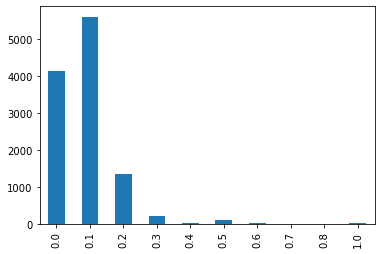

In [40]:
plot_percent_NE = onto_val['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print(len(onto_val))
print("there are", sum(plot_percent_NE.loc[0:0.01])/len(onto_val), "sentences in the range of 0:0.1")
print(sum(plot_percent_NE.loc[0:0.01]))

<AxesSubplot:xlabel='word_count'>

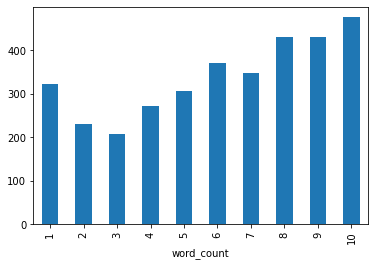

In [41]:
onto_val.groupby(by='word_count')['input_text'].count().head(10).plot(kind='bar')

### Combining the datasets

In [42]:
val_combined_df = pd.concat([conellpp_val, wikineural_val, onto_val], ignore_index=True).drop_duplicates().reset_index(drop=True)
val_combined_df

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTE...,*LEICESTERSHIRE*,9,1,0.1
1,LONDON 1996-08-30,*LONDON*,2,1,0.5
2,West Indian all-rounder Phil Simmons took four...,"*West Indian*,*Phil Simmons*,*Leicestershire*,...",34,6,0.2
3,"Their stay on top , though , may be short-live...","*Essex*,*Derbyshire*,*Surrey*,*Kent*,*Nottingh...",33,5,0.2
4,After bowling Somerset out for 83 on the openi...,"*Somerset*,*Grace Road*,*Leicestershire*,*Engl...",36,7,0.2
...,...,...,...,...,...
25917,one of the reasons I feel like I have to go ba...,"*one*,*one*,*October*",29,2,0.1
25918,Mr. Good devotes much serious space to the eve...,"*Feb. 25, 1942*,*Los Angeles*,*American*,*Good*",25,4,0.2
25919,And how about you ?,**,5,0,0.0
25920,Office director William Li was subsequently re...,*the Mainland Affairs Council*,18,1,0.1


### creating a lowercase and uppercase versions of the validation data (not needed)

In [43]:
# lower_val = lower_case_df(val_combined_df)
# lower_val

In [44]:
# upper_val = upper_case_df(val_combined_df)
# lower_upper_val = pd.concat([lower_val, upper_val])
# lower_upper_val = lower_upper_val.sample(frac=1, random_state=1).reset_index(drop=True)
# lower_upper_val

### Saving the data as csv

In [45]:
val_combined_df.to_csv('./1-NER_Data/1-csv_format/val/val_data.csv', index = False)
# lower_val.to_csv('./1-NER_Data/1-csv_format/val/lower_val_data.csv', index = False)
# lower_upper_val.to_csv('./1-NER_Data/1-csv_format/val/low_up_val_data.csv', index = False)

# Test data

### Read the data from either txt files or from huggingface dataset and converting each to target form  --->  [input_text, target_text, word_count, NE_count] 

In [19]:
# CoNLL2003++ test dataset

conellpp_test = parse_file_data("./1-NER_Data/0-raw_data/coNLL2003pp/conllpp_test.txt", in_position=0, pos_position=3, line_len=4, sep=' ')
conellpp_test

,input_text,target_text,word_count,NE_count
0,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...","*JAPAN*,*CHINA*",9,2
1,Nadim Ladki,*Nadim Ladki*,2,2
2,"AL-AIN , United Arab Emirates 1996-12-06","*AL-AIN*,*United Arab Emirates*",5,4
3,Japan began the defence of their Asian Cup tit...,"*Japan*,*Asian Cup*,*Syria*",24,4
4,But China saw their luck desert them in the se...,"*China*,*Uzbekistan*",23,2
...,...,...,...,...
3447,It all culminated in the fact that I now have ...,*Ireland*,17,1
3448,That is why this is so emotional a night for m...,*Charlton*,13,1
3449,""" It was the joy that we all had over the peri...",**,27,0
3450,"Charlton managed Ireland for 93 matches , duri...","*Charlton*,*Ireland*",24,2


In [20]:
# wikineural test dataset

wikineural_test = parse_file_data("./1-NER_Data/0-raw_data/wikineural/test.conllu.txt", 1, 2, 3, '\t')
wikineural_test

,input_text,target_text,word_count,NE_count
0,On this occasion he failed to gain the support...,*South Wales Miners ' Federation*,20,4
1,On both these occasions he was backed by the S...,*South Wales Miners ' Federation*,18,4
2,"He also appeared as himself in the 1996 film ""...",*Eddie*,10,1
3,The Colorado Rockies were created as an expans...,"*Colorado Rockies*,*Coors Field*",17,4
4,He kept busy recording demo tapes at his home ...,"*La Valencia Hotel*,*La Jolla*",29,5
...,...,...,...,...
11592,"com , Amazon .",*Amazon*,2,1
11593,"In January 2013 , the European Food Safety Aut...","*European Food Safety Authority*,*Monsanto*",27,5
11594,"All of the games had art true to the series , ...",*Sega*,23,1
11595,There was also a game made for the Game Boy ba...,*Game Boy*,20,2


In [48]:
# OntoNotes 5.0 test dataset refer section above

### Adding entity as percentage of the input sentence

In [49]:
conellpp_test = add_per_NE_sent(conellpp_test)
wikineural_test = add_per_NE_sent(wikineural_test)
onto_test = add_per_NE_sent(onto_test)

3452
there are 0.22624565469293165 sentences in the range of 0:0.1


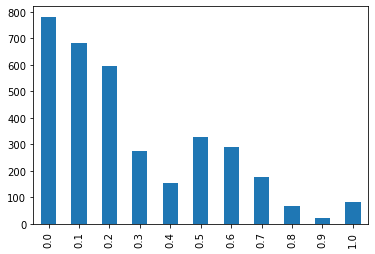

In [50]:
plot_percent_NE = conellpp_test['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print(len(conellpp_test))
print("there are", sum(plot_percent_NE.loc[0:0.099])/len(conellpp_test), "sentences in the range of 0:0.1")

<AxesSubplot:xlabel='word_count'>

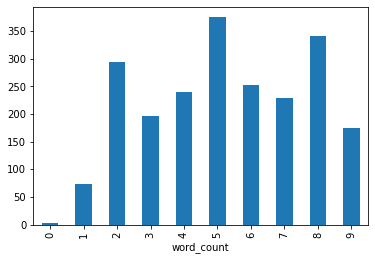

In [51]:
conellpp_test.groupby(by='word_count')['input_text'].count().head(10).plot(kind='bar')

In [52]:
conellpp_test = conellpp_test.drop(conellpp_test.loc[conellpp_test['word_count'] == 0].index).reset_index(drop=True)
conellpp_test

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...","*JAPAN*,*CHINA*",9,2,0.2
1,Nadim Ladki,*Nadim Ladki*,2,2,1.0
2,"AL-AIN , United Arab Emirates 1996-12-06","*AL-AIN*,*United Arab Emirates*",5,4,0.8
3,Japan began the defence of their Asian Cup tit...,"*Japan*,*Asian Cup*,*Syria*",24,4,0.2
4,But China saw their luck desert them in the se...,"*China*,*Uzbekistan*",23,2,0.1
...,...,...,...,...,...
3444,It all culminated in the fact that I now have ...,*Ireland*,17,1,0.1
3445,That is why this is so emotional a night for m...,*Charlton*,13,1,0.1
3446,""" It was the joy that we all had over the peri...",**,27,0,0.0
3447,"Charlton managed Ireland for 93 matches , duri...","*Charlton*,*Ireland*",24,2,0.1


there are 0.13460377683883762 sentences in the range of 0:0.1


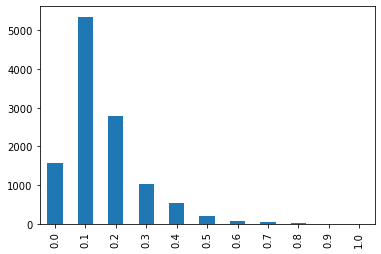

In [53]:
plot_percent_NE = wikineural_test['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print("there are", sum(plot_percent_NE.loc[0:0.099])/len(wikineural_test), "sentences in the range of 0:0.1")

<AxesSubplot:xlabel='word_count'>

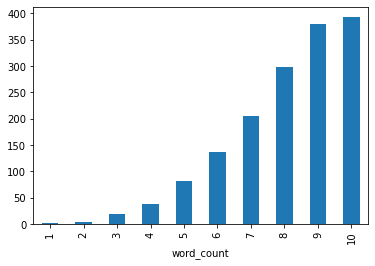

In [54]:
wikineural_test.groupby(by='word_count')['input_text'].count().head(10).plot(kind='bar')

11516
there are 0.6265090670303581 sentences in the range of 0:0.1


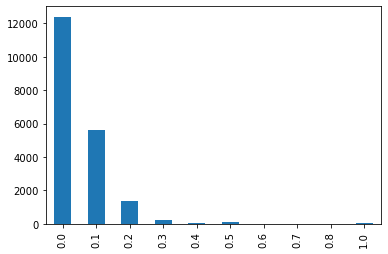

In [55]:
plot_percent_NE = onto_test['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print(len(onto_val))
print("there are", sum(plot_percent_NE.loc[0:0.099])/len(onto_test), "sentences in the range of 0:0.1")

In [56]:
# dropping half of the rows with zero entities randomly

np.random.seed(10)
zero_entities = onto_test.loc[onto_test['%_NE_in_sentence']==0].index
remove_n = round(len(zero_entities)*2/3)

drop_indices = np.random.choice(zero_entities, remove_n, replace=False)
onto_test.drop(drop_indices, inplace=True)
onto_test

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
128297,One of the major gang problems uh of the insan...,"*Hispanic*,*Hispanic*",27,1,0.0
54741,mhm.,**,1,0,0.0
64070,Welcome back to Hardball.,*Hardball*,4,1,0.2
44486,"At 9:45, Procter & Gamble--one of the most imp...","*2 3/4*,*117*,*Procter & Gamble*,*Dow*,*9:45*",18,3,0.2
104889,"Back then, it cost Japanese manufacturers abou...","*80*,*Japanese*",13,2,0.2
...,...,...,...,...,...
60999,Investment-grade corporate bonds were up about...,*3/4*,10,1,0.1
12552,--It can provide Hong Kong with more business ...,*Hong Kong*,9,1,0.1
115515,Out of the operating foreign-invested enterpri...,"*600,000*,*Liaoning*",32,2,0.1
81111,The ground shakes underneath her.,**,5,0,0.0


11528
there are 0.35860513532269256 sentences in the range of 0:0.1
4134


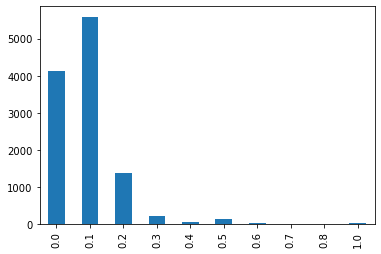

In [57]:
plot_percent_NE = onto_test['%_NE_in_sentence'].value_counts().sort_index()
plot_percent_NE.plot(kind='bar')
print(len(onto_test))
print("there are", sum(plot_percent_NE.loc[0:0.01])/len(onto_test), "sentences in the range of 0:0.1")
print(sum(plot_percent_NE.loc[0:0.01]))

<AxesSubplot:xlabel='word_count'>

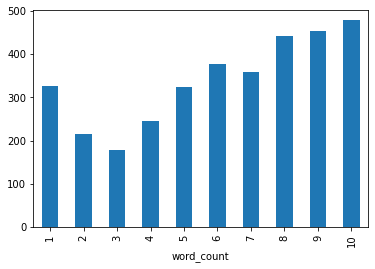

In [58]:
onto_test.groupby(by='word_count')['input_text'].count().head(10).plot(kind='bar')

### Combining the datasets

In [59]:
# test_combined_df = pd.concat([conellpp_test, wikineural_test, onto_test], ignore_index=True).drop_duplicates().reset_index(drop=True)
# test_combined_df

### creating a lowercase and uppercase versions of the test data

In [60]:
# lower_test = lower_case_df(test_combined_df)
# lower_test

In [61]:
# upper_test = upper_case_df(test_combined_df)
# lower_upper_test = pd.concat([lower_test, upper_test])
# lower_upper_test = lower_upper_test.sample(frac=1, random_state=1).reset_index(drop=True)
# lower_upper_test

### Saving the data as csv

In [62]:
# test_combined_df.to_csv('./1-NER_Data/1-csv_format/test/test_data.csv', index = False)

conellpp_test.to_csv('./1-NER_Data/1-csv_format/test/conell_test_data.csv', index = False)
wikineural_test.to_csv('./1-NER_Data/1-csv_format/test/wiki_neural_test_data.csv', index = False)
onto_test.to_csv('./1-NER_Data/1-csv_format/test/onto_test_data.csv', index = False)

# lower_test.to_csv('./1-NER_Data/1-csv_format/test/lower_test_data.csv', index = False)
# lower_upper_test.to_csv('./1-NER_Data/1-csv_format/test/low_up_test_data.csv', index = False)